In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
np.random.seed(1)

In [3]:
# Parameters
N = 2000  # number of nodes
alpha = 1.0  # decay rate
beta = 1.0  # interaction strength
dt = 0.01  # time step
steps = 20000  # total steps

In [4]:
# Using Barabási-Albert model which creates networks with gamma ≈ 3
m = 2 # number of edges to attach from a new node to existing nodes
G = nx.barabasi_albert_graph(N, m)
A = nx.adjacency_matrix(G).toarray()

# Initialize state vector x
x = np.zeros(N)

# Set last 10 nodes to random values between 0 and 0.1
x[1900:] = np.random.uniform(0, 1, 100) /10
x[1900:1920] = x[90]*10

# Store history for plotting
x_history = np.zeros((steps + 1, N))
x_history[0] = x

In [5]:
# Simulation using Euler method
def simulate_step(x, A, alpha, beta, dt):
    # Calculate sum of Aij*xj for each i
    interaction_term = np.dot(A, x)
    
    # Calculate dx/dt for each node
    dxdt = -alpha * x + beta * (1 - x) * interaction_term
    
    # Euler step
    x_new = x + dt * dxdt
    
    # Ensure values stay in [0, 1]
    x_new = np.clip(x_new, 0, 1)
    
    return x_new

In [6]:
# Run simulation
for t in range(steps):
    x = simulate_step(x, A, alpha, beta, dt)
    x_history[t + 1] = x

In [7]:
# Create time array
time = np.arange(0, (steps + 1) * dt, dt)

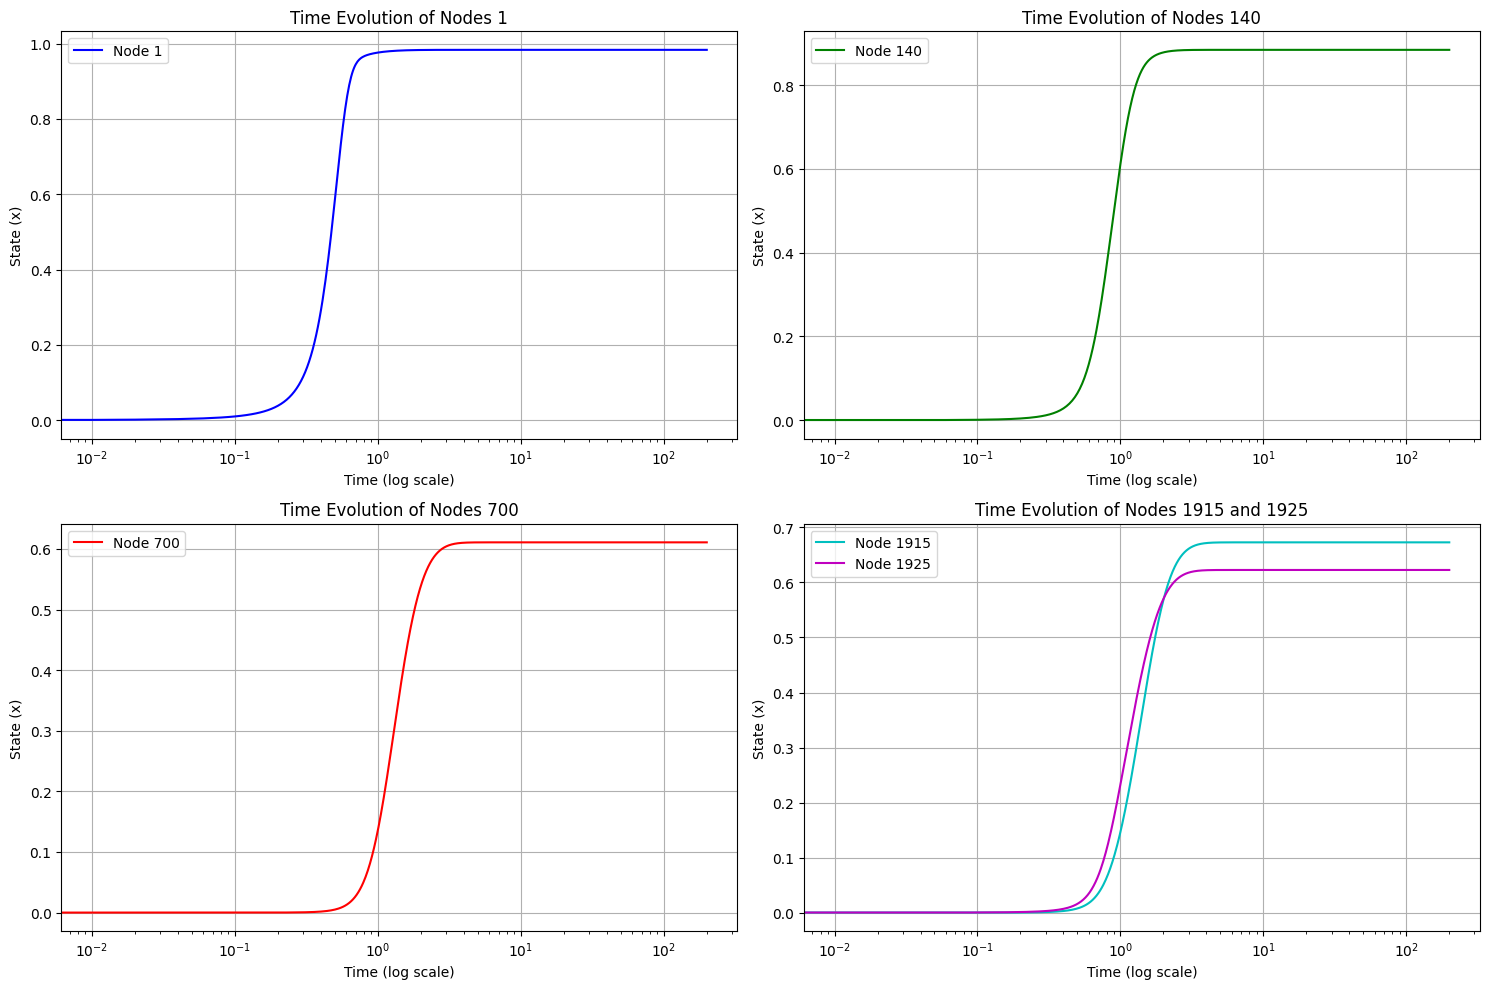

In [8]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot for nodes 1, 15, 80
plt.subplot(2,2,1)
plt.semilogx(time, x_history[:, 0], 'b-', label='Node 1')
plt.xlabel('Time (log scale)')
plt.ylabel('State (x)')
plt.title('Time Evolution of Nodes 1')
plt.grid(True)
plt.legend()

plt.subplot(2,2,2)
plt.semilogx(time, x_history[:, 139], 'g-', label='Node 140')
plt.xlabel('Time (log scale)')
plt.ylabel('State (x)')
plt.title('Time Evolution of Nodes 140')
plt.grid(True)
plt.legend()

plt.subplot(2,2,3)
plt.semilogx(time, x_history[:, 699], 'r-', label='Node 700')
plt.xlabel('Time (log scale)')
plt.ylabel('State (x)')
plt.title('Time Evolution of Nodes 700')
plt.grid(True)
plt.legend()

plt.subplot(2,2,4)
plt.semilogx(time, x_history[:, 955], 'c-', label='Node 1915')
plt.semilogx(time, x_history[:, 965], 'm-', label='Node 1925')
plt.xlabel('Time (log scale)')
plt.ylabel('State (x)')
plt.title('Time Evolution of Nodes 1915 and 1925')
plt.grid(True)
plt.legend()

plt.tight_layout()

### After Perturbation:

In [9]:
def perturb_simulate_step(x,A,alpha,beta,dt,perturbed_node,fixed_value):
   
    # Calculate sum of Aij*xj for each i
    interaction_term = np.dot(A, x)
    
    # Calculate dx/dt for each node
    dxdt = -alpha * x + beta * (1 - x) * interaction_term
    
    # Euler step
    x_new = x + dt * dxdt
    
    # Ensure values stay in [0, 1]
    x_new = np.clip(x_new, 0, 1)

    x_new[perturbed_node] = fixed_value
    
    return x_new

In [10]:
# Parameters
steps = 20000  # total steps
perturbed_node =  0
perturbation_constant = 0.3


In [11]:
x_history2 = np.zeros((steps+1,N))
x_history2[0] = x

# print("Before Perturbation",x)
fixed_value = np.clip(x[perturbed_node] + perturbation_constant, 0, 1)
print(x[perturbed_node])
x[perturbed_node] = fixed_value
# print("After Perturbation",x)

print(fixed_value)
# print(x_history2[1])

0.9834342621327905
1.0


In [12]:
# Run simulation
for t in range(steps):
    x = perturb_simulate_step(x, A, alpha, beta, dt,perturbed_node,fixed_value)
    x_history2[t + 1] = x

# print(x_history2[2] - x_history2[1])
# print(x_history2[1])



<Figure size 1500x1000 with 0 Axes>

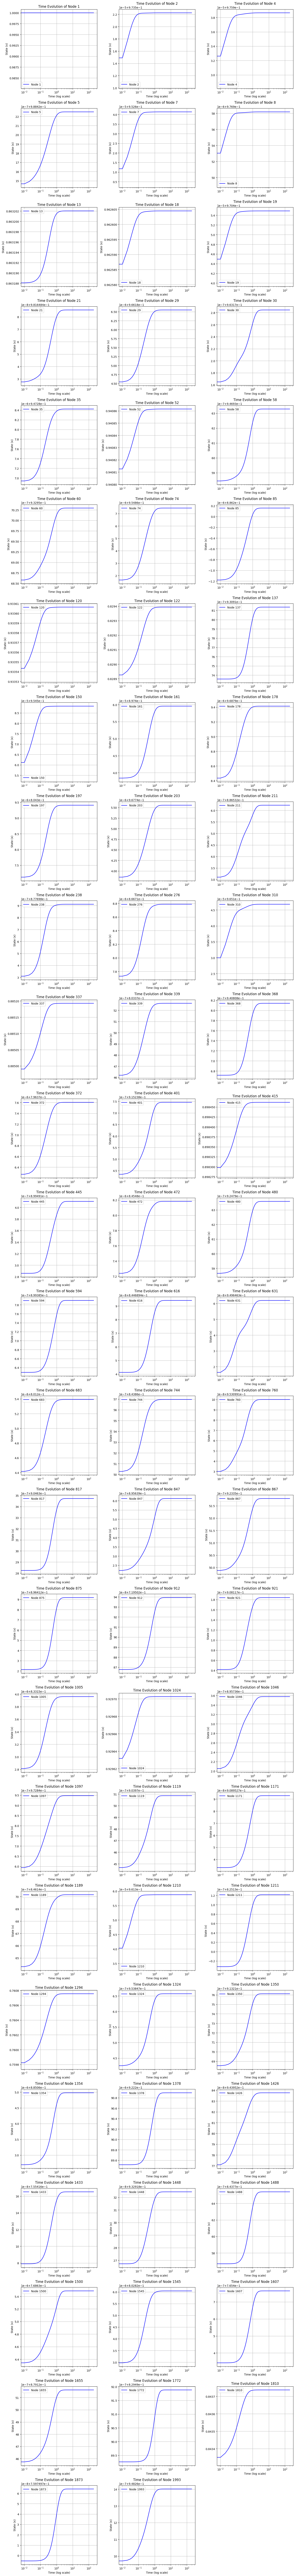

In [13]:
# Plotting
plt.figure(figsize=(15, 10))

adj_list =list(G.neighbors(perturbed_node))

num_plots = len(adj_list)  # Number of nodes to plot
# Determine number of rows and columns for subplots
cols = 3  # Adjust this to your desired number of columns
rows = (num_plots + cols - 1) // cols  # Compute the required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Dynamically sized grid

# Flatten axes array if necessary
axes = axes.flatten()

# Plot for all nodes in the adjacency list
for i, node in enumerate(adj_list):
    axes[i].semilogx(time, x_history2[:, i], 'b-', label=f'Node {node}')
    axes[i].set_xlabel('Time (log scale)')
    axes[i].set_ylabel('State (x)')
    axes[i].set_title(f'Time Evolution of Node {node}')
    axes[i].grid(True)
    axes[i].legend()

# Hide any unused subplots
for j in range(len(adj_list), len(axes)):
    axes[j].axis('off')

plt.tight_layout()

In [14]:
def calculate_steady_state(time_series, threshold=1e-20):
    for t in range(len(time_series)-1):
        if np.abs(time_series[t] - time_series[t-1]) < threshold:
            # print("yes")
            # print(np.abs(time_series[t] - time_series[t-1]))
            # print(t)
            return t  # Steady state reached at time 't'
    return len(time_series)  # If steady state not reached, return the last time step

In [15]:
# Function to calculate half-life of a node
def calculate_half_life(time_series, perturbation_time):
    # Calculate the change after perturbation
    initial_value = time_series[perturbation_time]  # Value right after perturbation
    steady_value = time_series[-1]  # Assuming the steady state is at the last time step

    # Calculate the change caused by the perturbation
    change_due_to_perturbation = steady_value - initial_value
    
    # Half of the change due to perturbation
    half_change = initial_value + change_due_to_perturbation / 2

    # Find the time when the node reaches half of the perturbation change
    for t in range(perturbation_time, len(time_series)):
        if time_series[t] >= half_change:
            return t*0.01  # Half-life is the time taken to reach half of the perturbation change

    return None  # Return None if no half-life is detected


# Calculate half-lives for nodes adjacent to the perturbed node
half_lives = []
for node in adj_list:
    node_series = x_history2[:, node]
    steady_state_time = calculate_steady_state(node_series)
    half_life = calculate_half_life(node_series, 0)
    degree = G.degree(node)
    half_lives.append((node, degree, half_life))

# # Print a table with Node, Degree, and Half-Life
print("Node | Degree | Half-Life")
for node, degree, half_life in half_lives:
    print(f"{node:4d} | {degree:6d} | {half_life:.2f}" if half_life else 'Not detected')




# print(half_lives)


Node | Degree | Half-Life
   1 |     48 | 0.02
   2 |     51 | 0.02
   4 |     26 | 0.03
   5 |     55 | 0.02
   7 |     32 | 0.03
   8 |     44 | 0.02
  13 |     21 | 0.04
  18 |     18 | 0.05
  19 |      6 | 0.12
  21 |     27 | 0.03
  29 |     37 | 0.03
  30 |     10 | 0.08
  35 |     11 | 0.08
  52 |     17 | 0.05
  58 |     34 | 0.03
  60 |      4 | 0.17
  74 |      7 | 0.11
  85 |      7 | 0.11
 120 |      5 | 0.14
 122 |      2 | 0.24
 137 |      8 | 0.11
 150 |      2 | 0.24
 161 |     16 | 0.06
 178 |      5 | 0.15
 197 |      7 | 0.11
 203 |      5 | 0.15
 211 |      8 | 0.10
 238 |      5 | 0.14
 276 |     10 | 0.09
 310 |      9 | 0.10
 337 |      2 | 0.24
 339 |      4 | 0.17
 368 |      4 | 0.17
 372 |      8 | 0.10
 401 |      5 | 0.14
 415 |      8 | 0.10
 445 |      4 | 0.17
 472 |      4 | 0.17
 480 |      4 | 0.17
 594 |      2 | 0.23
 616 |      4 | 0.17
 631 |      2 | 0.24
 683 |      2 | 0.23
 744 |      3 | 0.21
 760 |      4 | 0.17
 817 |      3 | 0.19
 847 |  

In [16]:
half_life = [item[2] for item in half_lives]
degree = [item[1] for item in half_lives]

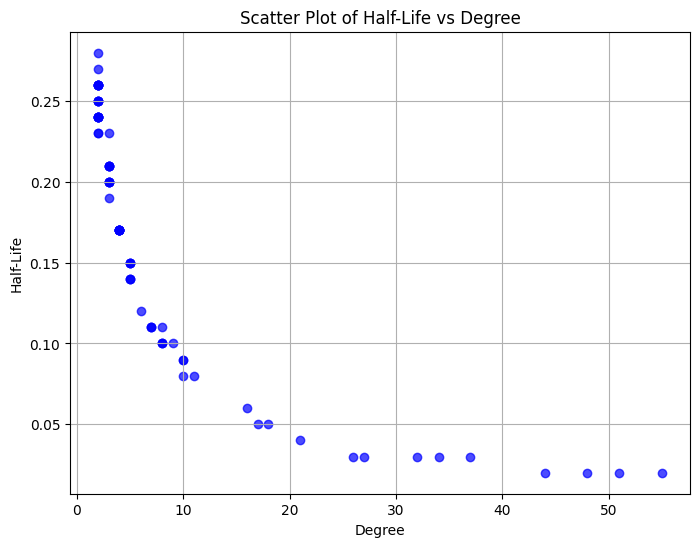

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(degree, half_life, color='blue', alpha=0.7)
plt.title('Scatter Plot of Half-Life vs Degree')
plt.xlabel('Degree')
plt.ylabel('Half-Life')
plt.grid(True)
plt.show()

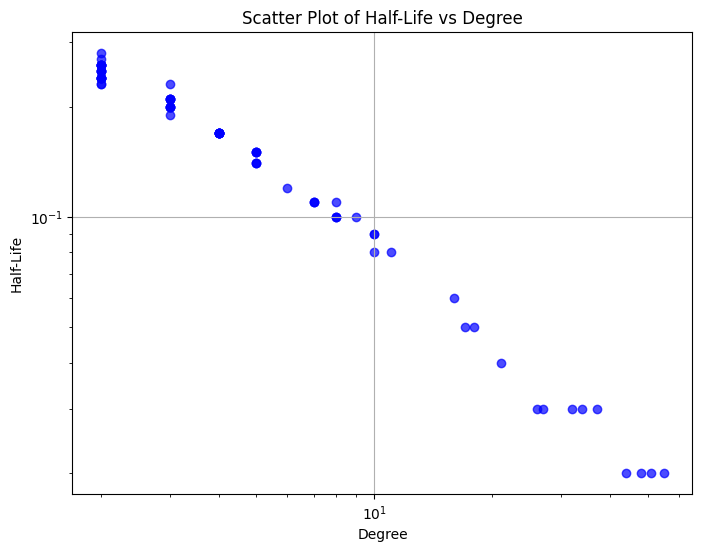

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(degree, half_life, color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot of Half-Life vs Degree')
plt.xlabel('Degree')
plt.ylabel('Half-Life')
plt.grid(True)
plt.show()

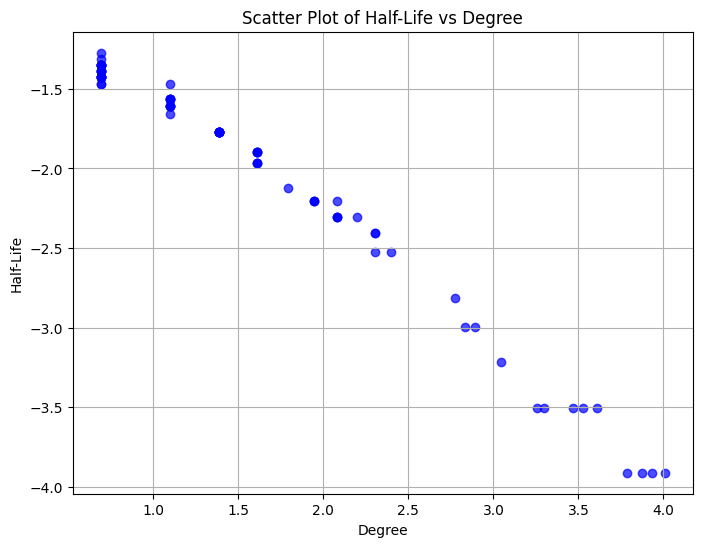

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(np.log(degree), np.log(half_life), color='blue', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Scatter Plot of Half-Life vs Degree')
plt.xlabel('Degree')
plt.ylabel('Half-Life')
plt.grid(True)
plt.show()